In [33]:
from lbg_forecast.likelihood import Likelihood
import lbg_forecast.utils as utils

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk
import lbg_forecast.angular_power as ap

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_cosmo as jc
import pyccl as ccl
import scipy as sc

In [2]:
path = "./"
lhood = Likelihood(path)

Initialising likelihood
Initialisation Complete


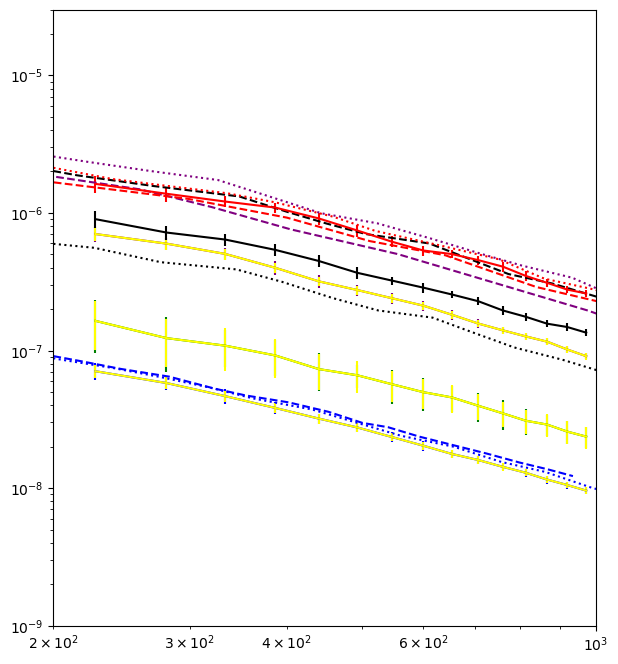

In [71]:
def get_params(du, dg, dr):

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    du, dg, dr])

    cosmo_obj = jc.Planck15(sigma8=params[0],
                            Omega_c=params[1],
                            Omega_b=params[2],
                            h=params[3],
                            n_s=params[4])

    bias_params = lhood._bias_params
    bias_params = bias_params.at[0].set(params[5])
    bias_params = bias_params.at[1].set(params[6])
    bias_params = bias_params.at[2].set(params[7])
    nz_params = lhood.nz_params_mean

    return cosmo_obj, nz_params, bias_params

def bin_curve(curve):

    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(lhood._ell, curve, statistic='mean', bins=15)
    bin_stds, bin_edges, binnumber = sc.stats.binned_statistic(lhood._ell, curve, statistic='std', bins=15)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    return bin_centers, bin_means, bin_stds

def noise_in_auto_cls(ell, cl, fsky):
    return ((2/(fsky*(2*ell+1)))*(cl**2))**(0.5)

def noise_in_cross_cls(ell, cla1, cla2, clc1, clc2, fsky):
    norm = 1/(fsky*(2*ell+1))

    return (norm*(cla1*cla2 + clc1*clc2))**(0.5)


cosmo_obj, nz_params, bias_params = get_params(3, 4, 5)
#cl = ap.cl_theory_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, lhood.ndens*9999999)

#cls_split = np.split(cl, 10)

cl_noisey, covmat = ap.cl_data_CMB(cosmo_obj, nz_params, bias_params, lhood._ell, 0.35, lhood.ndens*9999999, seed=100, ncls=4)
auto_noisey = np.split(cl_noisey, 10)

bin_centers, bin_means, bin_stds = bin_curve(auto_noisey[0])
plt.errorbar(bin_centers, bin_means, bin_stds,  c='purple', alpha=1.0)
plt.errorbar(bin_centers, bin_means, noise_in_auto_cls(bin_centers, bin_means, lhood._fsky), c='yellow', alpha=1.0)
bin_centers, bin_means, bin_stds = bin_curve(auto_noisey[4])
plt.errorbar(bin_centers, bin_means, bin_stds,  c='black', alpha=1.0)
bin_centers, bin_means, bin_stds = bin_curve(auto_noisey[7])
plt.errorbar(bin_centers, bin_means, bin_stds,  c='red', alpha=1.0)

bin_centers, bin_means, bin_stds = bin_curve(auto_noisey[9])
plt.errorbar(bin_centers, bin_means, bin_stds,  c='blue', alpha=1.0)
plt.errorbar(bin_centers, bin_means, noise_in_auto_cls(bin_centers, bin_means, lhood._fsky), c='yellow', alpha=1.0)


bin_centers, bin_means_ug, bin_stds_ug = bin_curve(auto_noisey[1])
bin_centers, bin_means_uu, bin_stds_uu = bin_curve(auto_noisey[0])
bin_centers, bin_means_gg, bin_stds_gg = bin_curve(auto_noisey[4])
bin_centers, bin_means_gu, bin_stds_gu = bin_curve(auto_noisey[5])
plt.errorbar(bin_centers, bin_means_ug, bin_stds_ug,  c='green', alpha=1.0)
plt.errorbar(bin_centers, bin_means_ug, noise_in_cross_cls(bin_centers, bin_means_uu, bin_means_gg, bin_means_ug, bin_means_gu, lhood._fsky), c='yellow', alpha=1.0)


plt.yscale('log')
plt.xscale('log')
plt.xlim(200, 1000)
plt.ylim(1e-9, 3e-5)
fig = plt.gcf()
fig.set_size_inches(7, 8)



x1 = np.array([1178.7686347935867, 976.7781100894882, 711.2803588203334, 555.7736586486875, 404.70899507597613, 319.96468029136963, 258.97945113819964, 125.00827878772655, 102.37739663395848])
y1 = np.array([1.3433993325989014e-7, 1.9525325860315103e-7, 3.3217544185377504e-7, 5.021745520652799e-7, 7.591749689098774e-7, 0.0000011034052417075069, 0.0000014823138652959944, 0.0000027283333764867697, 0.000003131313106003991])

plt.plot(x1, y1, ls='--', c='purple')

x2 = [137.32673733736806, 173.6984401348871, 214.60145050354197, 268.26957952797244, 347.38921120831156, 399.9823395608933, 449.8432668969444, 505.9197488435822, 610.5402296585327, 686.6488450042998, 772.2449945836254, 878.7747120756408, 988.3208538169617, 1151.395399326447]
y2 = [0.0000027283333764867697, 0.0000023308877933907038, 0.0000018771728898666807, 0.0000015724657563836946, 0.000001317219403895693, 0.0000010198751465593192, 8.376776400682924e-7, 7.017038286703837e-7, 5.994842503189409e-7, 4.641588833612782e-7, 3.5938136638046254e-7, 3.07029062975785e-7, 2.521792807419645e-7, 1.9525325860315103e-7]

plt.plot(x2, y2, ls='--', c='black')

x3 = [101.18171605283169, 298.1877485606114, 399.9823395608933, 511.8982837301126, 639.915233634926, 838.4349775221377, 1048.1131341546852, 1279.8022139979525]
y3 = [0.000002675164097969399, 0.0000012663801734674021, 9.242978989125283e-7, 6.235507341273925e-7, 4.923882631706742e-7, 2.894266124716752e-7, 2.1544346900318867e-7, 1.4534267947373484e-7]

plt.plot(x3, y3, ls='--', c='red')

xwwu = np.array([125.5623153972163, 152.23324528580937, 182.96053201543515, 221.8235261098525, 266.5971567143719, 326.0678536966673, 375.09777385637483, 442.98378818440153, 523.1559616489249, 612.4522625122507, 716.9903458121964, 803.4206051255157, 932.3559550487637, 1053.934662748247, 1201.8434716538877])
ywwu = np.array([0.00000389263696492945, 0.0000033449547255342967, 0.000002779088896298601, 0.0000023481817441181603, 0.0000020177996797972005, 0.0000017339013719820553, 0.0000013466920386760548, 9.943996793887978e-7, 8.402146389083458e-7, 6.525805811569862e-7, 4.983804244327173e-7, 4.1406943212133176e-7, 3.382737459372359e-7, 2.497819062154195e-7, 2.0064993546611555e-7])

plt.plot(xwwu, ywwu, ls=':', c='purple')

xwwg = np.array([129.67028546334132, 174.2790308455268, 199.3475465253271, 225.98811680013927, 275.2255295178327, 344.3221651312178, 393.8498997853398, 458.64704443915775, 524.6194139734372, 616.4292931060073, 686.3977883319686, 785.1301122145344, 785.1301122145344, 906.1465547871918, 1074.3069978730812, 1320.1478358332706])
ywwg = np.array([9.020360210610162e-7, 6.852055871304984e-7, 5.971994553657484e-7, 5.575305334261898e-7, 4.3831975510038276e-7, 3.886442429421119e-7, 3.162277660168379e-7, 2.402132808683883e-7, 1.9545409601731868e-7, 1.7330295587336474e-7, 1.3860887695644154e-7, 1.0529022644209164e-7, 1.0529022644209164e-7, 8.567139149967783e-8, 6.396908655342065e-8, 4.615078626856145e-8])

plt.plot(xwwg, ywwg, ls=':', c='black')

xwwr = np.array([104.58159303515961, 130.8372831903477, 159.34360202923685, 194.06076684359735, 238.46898686867357, 275.2255295178327, 335.1905983860327, 386.85537747094713, 458.64704443915775, 519.9400928447668, 627.5746169064993, 750.7345120958131, 858.7211114964164, 1000, 1143.8412616720364, 1285.1369672421383, 1510.039566133138])
ywwr = np.array([0.000003253233763380842, 0.00000298792339069335, 0.0000026524384825975824, 0.0000021997054560742663, 0.0000017632155964370444, 0.000001592100370263148, 0.000001389495494373136, 0.0000011922152694269093, 9.395208098992636e-7, 7.403858806959234e-7, 5.83458340207125e-7, 4.5979217544947297e-7, 3.3278786973763393e-7, 2.759857759491969e-7, 2.0666690516307238e-7, 1.6850041903051102e-7, 1.3278612865947423e-7])

plt.plot(xwwr, ywwr, ls=':', c='red')

xcmbss = np.array([112.53355826007646, 135.47779883625893, 159.02492574711638, 186.66473197900515, 217.2682853558807, 244.49973248162917, 282.19508836901434, 322.9665238628857, 354.36477855785466, 402.1569739810728, 452.561552611951, 500.7646916070944, 540.2574104461664, 592.7803145885002, 655.918404275484, 725.78144462499, 796.3406789959573, 866.4209355830732, 934.7510694338745])
ycmbss = np.array([1.505116419197826e-7, 1.322803474907371e-7, 1.1296905648621063e-7, 9.787104053000563e-8, 8.358308180867636e-8, 7.345876348814988e-8, 6.456079168700595e-8, 5.281307236606017e-8, 4.70865852497005e-8, 4.198101741004073e-8, 3.5852309259132986e-8, 2.9752279773021634e-8, 2.7692846680088923e-8, 2.36500343415412e-8, 2.0489269730773872e-8, 1.7750932960085058e-8, 1.5378567664623763e-8, 1.3711079566428443e-8, 1.2224396119112233e-8])
plt.plot(xcmbss, ycmbss, c='blue', ls='--', label='schmittful-cmblens')

xcmbww = np.array([109.14976718158549, 127.78029261550866, 149.5908200494967, 175.12413679012786, 203.2285838418866, 240.0093367978813, 276.09887609889904, 317.61509947953084, 362.18908752160166, 431.500187328789, 492.0567673580837, 561.1118358991577, 656.8867385849629, 755.6609783073264, 861.7101663532516, 991.2831376784529, 1120.5459178329834, 1244.678059811241])
ycmbww = np.array([1.584893192461114e-7, 1.316776887700438e-7, 1.1507357611050604e-7, 1.0227184660173215e-7, 8.641425016928875e-8, 7.425602671440081e-8, 6.380842850117596e-8, 5.391471540435065e-8, 4.479396560543792e-8, 3.721617260914331e-8, 2.989577085651788e-8, 2.4015288312744035e-8, 1.9952623149688786e-8, 1.5496866881000183e-8, 1.3094025149558946e-8, 1e-8, 8.449466108283348e-9, 7.020070335161489e-9])
plt.plot(xcmbww, ycmbww, c='blue', ls=':', label='wilson-cmblens')

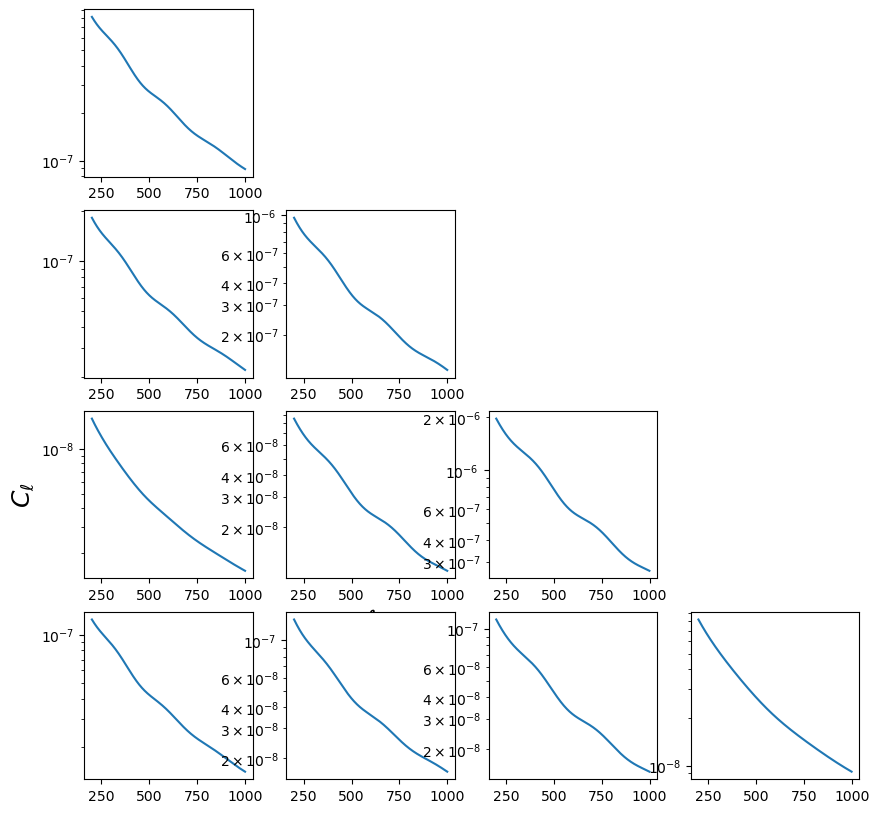

In [4]:
ap.plot_ncls(cl, lhood._ell, (10, 10), 18, 4)